<h1 style="text-align:center"> MCHE 485: Mechanical Vibrations</h1>
<h2 style="text-align:center">System Identification &mdash; Mini-Project 1 <br> Spring 2018</h2>
<p style="text-align:center">Dr. Joshua Vaughan<br>
<a href="mailto:joshua.vaughan@louisiana.edu">joshua.vaughan@louisiana.edu</a><br>
http://www.ucs.louisiana.edu/~jev9637/</p>

This notebook will demonstrate the basic methods to conduct system identifiation, *i.e.* finding natural frequency and damping ratio, for a system in which one mode is dominant. It implements a [zero-crossings](https://en.wikipedia.org/wiki/Zero_crossing) method to estimate natrual frequency, [logrithmic decrement (log dec)](https://en.wikipedia.org/wiki/Logarithmic_decrement) to estimate damping ratio, and a [Fast Fourier Transform (FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform) to get an additional estimate of natural frequency.

The notebook will first open a dialog box, asking the user what data file should be used. There are several files included in the `Data` folder that can be used. Once the file is imported, the data is smoothed (to reduce noise) and detrended (to remove bias). 

For the analysis in this notebook, the data files may need to be trimmed to only include the free-vibration part of the response.

In [1]:
import numpy as np
from scipy import signal

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

In [3]:
# This is the cell that will ask the user to select the data file. 
# It will open a "normal" file selection window.
import tkinter
from tkinter import filedialog

# Read in the text file to parse
root = tkinter.Tk()

#  This line may need to be commented out in Windows
root.withdraw()

file_path = filedialog.askopenfilename(title = "Select data file to process")

# These two lines are needed to force the file dialog box to close
root.update()
root.destroy()

In [4]:
# Now, load the data from the text file selected
data = np.genfromtxt(file_path, delimiter=',', skip_header=1)

time = data[:, 0]

# There are two types of data files, here we determine which we're opening
if np.shape(data)[1] is 3:
    vib = data[:, 1]
if np.shape(data)[1] is 6:
    vib = data[:, 2]
else:
    vib = data[:, 4]

In [5]:
# We'll use this function to smooth the data

def smooth(x, window_len=11, window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    
    From: http://wiki.scipy.org/Cookbook/SignalSmooth
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')

    y = np.convolve(w/w.sum(), s, mode='valid')
    
    return y

In [6]:
# Now that we've defined the smoothing function, let's use it
window_size = 64
vib_smoothed = smooth(vib, window_size)

# We can also remove any nonzero trends in the data
vib_detrend = signal.detrend(vib_smoothed)

# Define a range to match the time vector, 
# adjusting for the change in size due to the smoothing window
vib_shifted = vib_detrend[(window_size//2):(len(time) + window_size//2)]

Let's compare the raw data with it after our simple processing.

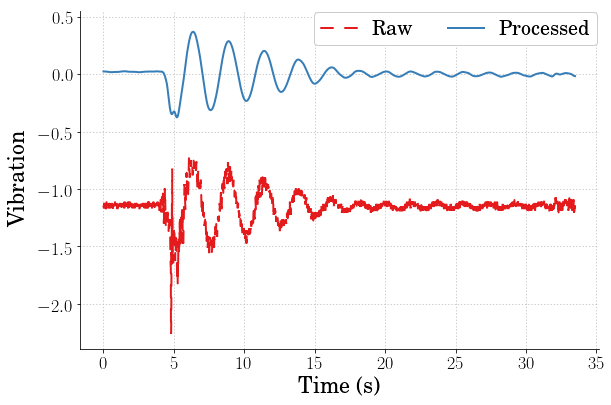

In [7]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)

# Change the axis units to CMU Serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Vibration', family='serif', fontsize=22, weight='bold', labelpad=10)

plt.plot(time, vib, linewidth=2, linestyle="--", label=r'Raw')
plt.plot(time, vib_shifted, linewidth=2, label=r'Processed')

# uncomment below and set limits if needed
# plt.xlim(0,5)
plt.ylim(ymax=1.5 * np.max((np.max(vib), np.max(vib_shifted))))

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol=2, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=20)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# save the figure as a high-res pdf in the current folder
# plt.savefig('processed_vibration_data.pdf', dpi=600)

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook

**Note:**    
This is the main place that you'll have to modify this notebook for this mini-project. You should trim the response such that only the free vibration portion is being analyzed. For example, in the plot above, you'd want to trim approximately the first 3 seconds from the beginning of the response. You'll want to trim the <span><tt>vib_shifted</tt></span> array.

For help in trimming NumPy arrays, see the [SciPy Lecture Notes](https://scipy-lectures.github.io/intro/numpy/array_object.html#indexing-and-slicing).

In the code block below, one way to do this is demonstrated. The user (*i.e.* you) needs to specify the time range of the free vibration portion of the response, using the `freeVib_time_start` variable to define its start time and `freeVib_time_end` variables. These are then used to find the index of the time array that most closely matches those times. Uses those two indices, the `time` and `vib_shifted` arrays are trimmed and saved to `time_clipped` and `vib_data`, respectively. These new arrays should contain only the free vibration part of the response. We also take the extra step of re-centering the response around zero, again using the `signal.detrend()` function.

In [8]:
freeVib_time_start = 5.5    # Time that the free vibration part of the response begins
freeVib_time_end = 17.5      # Time the the free vibration part of the response ends

# Find the index in the time array that is closest to the start and end times of the region. 
# We just look for the index where the difference is minimized.
index_start = np.argmin(np.abs(time - freeVib_time_start))
index_end = np.argmin(np.abs(time - freeVib_time_end))

# Now, using those indieces, we create new arrays containing the clipped region
time_freeVib = time[index_start:index_end]

# For the vibration data, we also detrend it again, based on the new range
freeVib_data = signal.detrend(vib_shifted[index_start:index_end])

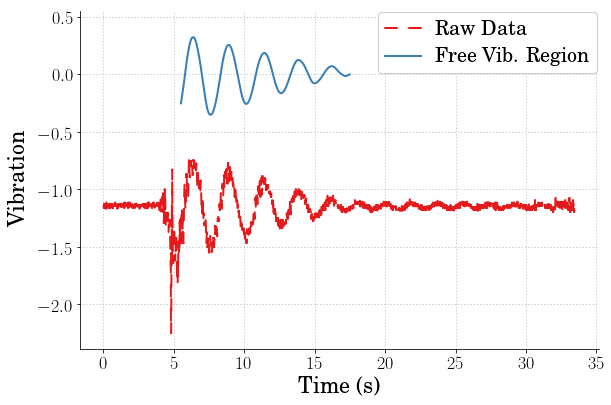

In [9]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Vibration', family='serif', fontsize=22, weight='bold', labelpad=10)

plt.plot(time, vib, linewidth=2, linestyle="--", label=r'Raw Data')
plt.plot(time_freeVib, freeVib_data, linewidth=2, linestyle='-', label=r'Free Vib. Region')

# uncomment below and set limits if needed
# plt.xlim(0, 5)
plt.ylim(ymax=1.5 * np.max((np.max(vib), np.max(vib_shifted))))

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 1, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext, family='serif', fontsize=20)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('free_vibration_region.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

# System Characterization/System ID
The next cell implements the functions necessary to actually perform the system identificaiton.

In [10]:
# First define all the functions we'll need.
def log_dec(peak1, peak2, num_cycles):
    '''##########################################################################################
    # log_dec.py
    #
    # Script to compute damping ratio using log dec method
    #
    # Inputs:
    #   peak1 = the amplitude of the first peak
    #   peak2 = the amplitude of the Nth peak
    #   num_cycles = the number of periods between two peaks
    # 
    # Output:
    #   zeta = the damping ratio
    #
    # NOTE: Plotting is set up for output, not viewing on screen.
    #       So, it will likely be ugly on screen. The saved PDFs should look
    #       better.
    #
    # Created: 03/28/14
    #   - Joshua Vaughan
    #   - joshua.vaughan@louisiana.edu
    #   - http://www.ucs.louisiana.edu/~jev9637
    #
    # Modified:
    #   * 03/17/16 - JEV - joshua.vaughan@louisiana.edu
    #       - updated for Python 3
    #
    ######################################################################################
    '''
    import numpy as np

    delta = 1 / num_cycles * np.log(peak1 / peak2)

    zeta = 1 / np.sqrt(1 + (2 * np.pi/delta)**2)
    
    return zeta
    

def get_local_Extrema(time,data):
    ''' # Function to get the local extrema for a response
    #
    # Inputs:
    #   time = time array corresponding to the data
    #   data = the response data array (only pass a single dimension/state at at time)
    #
    # Output:
    #   localMaxes = the amplitude of the local maxes
    #   localMax_Times = the times of the local maxes
    #
    # Created: 03/28/14
    #   - Joshua Vaughan
    #   - joshua.vaughan@louisiana.edu
    #   - http://www.ucs.louisiana.edu/~jev9637
    #
    # Modified:
    #   * 03/17/16 - JEV - joshua.vaughan@louisiana.edu
    #       - updated for Python 3
    #
    ######################################################################################
    '''
    from scipy import signal
    
    # Get local maximums
    localMax_indexes = signal.argrelextrema(data, np.greater)
    localMaxes = data[localMax_indexes]
    localMax_Times = time[localMax_indexes]

    # Get local minimums
    localMin_indexes = signal.argrelextrema(data, np.less)
    localMins = data[localMin_indexes]
    localMin_Times = time[localMin_indexes]
    
    return localMaxes, localMax_Times, localMins, localMin_Times
    

def get_zero_crossings(time,data):
    ''' Function to get the local extrema for a response
    #
    # Inputs:
    #   time = time array corresponding to the data
    #   data = the response data array (only pass a single dimension/state at at time)
    #   
    # Output:
    #   zeros = an array of the times of the zero crossings
    #
    # Created: 03/28/14
    #   - Joshua Vaughan
    #   - joshua.vaughan@louisiana.edu
    #   - http://www.ucs.louisiana.edu/~jev9637
    #
    # Modified:
    #   * 03/17/16 - JEV - joshua.vaughan@louisiana.edu
    #       - updated for Python 3
    #
    ######################################################################################
    '''
    
    # create an empty zeros array
    zeros = []
    
    for index in range(len(time)-1):
        if np.sign(data[index]) != np.sign(data[index + 1]):
            zeros.append(time[index])
    
    return zeros


def CRAWLAB_fft(data, time, plotflag):
    ''' Function to get the FFT for a response
    #
    # Inputs:
    #   time = time array corresponding to the data
    #   data = the response data array (only pass a single dimension/state at at time)
    #   plotflag = will plot the FFT if nonzero
    #   
    # Output:
    #   fft_freq = an array of the freqs used in the FFT
    #   fft_mag = an array of the amplitude of the FFT at each freq in fft_freq
    #
    # Created: 03/28/14
    #   - Joshua Vaughan
    #   - joshua.vaughan@louisiana.edu
    #   - http://www.ucs.louisiana.edu/~jev9637
    #
    # Modified:
    #   * 03/17/16 - JEV - joshua.vaughan@louisiana.edu
    #       - updated for Python 3
    ######################################################################################
    '''
    
    from scipy.fftpack import fft
    
    # correct for any DC offset
    offset = np.mean(data) 

    # Get the sampling time
    sample_time = time[1] - time[0]
    
    # Get the length of the dataset
    n = len(data)

    # Calculate the FFT of the data, removing the offset and using a Hanning Window
    fft_mag = fft((data - offset) * np.hanning(len(data)))
    
    # Define the frequency range of the output
    fft_freq = np.linspace(0.0, 1.0 / (2.0*sample_time), int(np.ceil(n/2)))
    
    # Only return the "useful" part of the fft
    fft_mag = 2.0/n * np.abs(fft_mag[0:int(np.ceil(n/2))])
    
    # If plotflag is nonzero (True), plot the FFT before returning the magnitude and phase
    if plotflag:
        # Plot the relationshiop
        #   Many of these setting could also be made default by the .matplotlibrc file
        fig = plt.figure(figsize=(6,4))
        ax = plt.gca()
        plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
        plt.setp(ax.get_ymajorticklabels(),fontsize=18)
        plt.setp(ax.get_xmajorticklabels(),fontsize=18)
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.grid(True, linestyle=':', color='0.75')
        ax.set_axisbelow(True)

        plt.xlabel('Frequency (Hz)', fontsize=22, labelpad=8)
        plt.ylabel('FFT magnitude', fontsize=22, labelpad=10)
    
        plt.plot(fft_freq, fft_mag, linewidth=2, linestyle='-')
        
        # Adjust the page layout filling the page using the new tight_layout command
        plt.tight_layout(pad=0.5)
        plt.show()
    
    return fft_freq, fft_mag

# System ID
Now, we can start the actual system identifcation part.

In [11]:
# Should return the zero crossings
zeros = get_zero_crossings(time_freeVib, freeVib_data)

# Get the peaks of the response
localMaxes, localMax_Times, localMins, localMin_Times = get_local_Extrema(time_freeVib, freeVib_data)

# Calculate the damping ratio from both the local maxes and the local minimums
zeta_maxes = log_dec(localMaxes[0], localMaxes[-1], len(localMaxes)-1)
zeta_mins = log_dec(localMins[0], localMins[-1], len(localMins)-1)

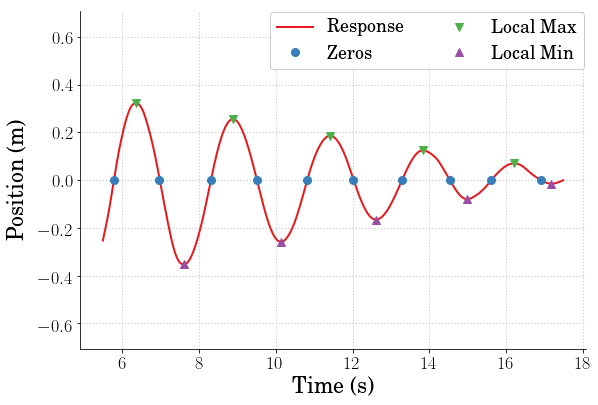

In [12]:
# We can plot these to check our results
# Let's plot our results
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)',family='serif',fontsize=22,weight='bold',labelpad=5)
plt.ylabel('Position (m)',family='serif',fontsize=22,weight='bold',labelpad=10)

plt.plot(time_freeVib, freeVib_data, linewidth=2,linestyle="-",label=r'Response')
plt.plot(zeros,np.zeros_like(zeros),'o', markersize = 8, label=r'Zeros')
plt.plot(localMax_Times, localMaxes, 'v', markersize = 8, label=r'Local Max')
plt.plot(localMin_Times, localMins, '^', markersize = 8, label=r'Local Min')

# uncomment below and set limits if needed
# plt.xlim(0,5)
plt.ylim(2*np.min(freeVib_data), 2.2*np.max(freeVib_data))

# # Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 2, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# save the figure as a high-res pdf in the current folder
# plt.savefig('zeroCrossings_and_localExtrema.pdf', dpi=600)

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook

Do a visual check now. If it looks like we found the right parts, then get the natural frequency and damping.

In [13]:
# Average the damping ratio from the positive and negative sides of the plot.
zeta_fromLogDec = np.mean([zeta_maxes, zeta_mins]) 

print('\nThe damping ratio found from the positive peaks is {:.4f}'.format(zeta_maxes))
print('The damping ratio found from the negative peaks is {:.4f}'.format(zeta_mins))
print('The damping ratio found from the log dec is {:.4f}\n'.format(zeta_fromLogDec))


The damping ratio found from the positive peaks is 0.0607
The damping ratio found from the negative peaks is 0.1248
The damping ratio found from the log dec is 0.0927



In [14]:
# Now let's get the frequency from the zero crossings

# Slice the zeros array to get every other value
zeros_slope1 = zeros[0:-1:2]
zeros_slope2 = zeros[1:-1:2]

# Calculate the period for both
period_slope1 = (zeros_slope1[-1] - zeros_slope1[0]) / (len(zeros_slope1) - 1)
period_slope2 = (zeros_slope2[-1] - zeros_slope2[0]) / (len(zeros_slope2) - 1)

period_fromZeros = np.mean([period_slope1, period_slope2])
freq_fromZeros = 1.0 / period_fromZeros

print('\nThe natrual frequency found from zero crossings is {:.4f} Hz.\n'.format(freq_fromZeros))


The natrual frequency found from zero crossings is 0.4019 Hz.




The highest magnitude peak occurs at 0.4168 Hz.



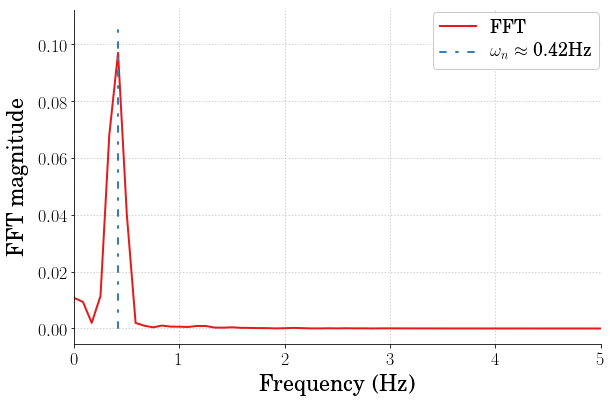

In [15]:
# We can also use the FFT to get the natrual frequency
freq, mag = CRAWLAB_fft(freeVib_data, time_freeVib, False)

# Let's plot the FFT manually so that we can scale the axes to our liking

# Plot the relationshiop
#   Many of these setting could also be made default by the .matplotlibrc file
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax.get_ymajorticklabels(),fontsize=18)
plt.setp(ax.get_xmajorticklabels(),fontsize=18)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

plt.xlabel('Frequency (Hz)',fontsize=22,labelpad=8)
plt.ylabel('FFT magnitude',fontsize=22,labelpad=10)

plt.plot(freq, mag, linewidth=2, linestyle='-', label = 'FFT')

# Plto and output the location of the highest peak - The fundamental frequency
freq_index = np.argmax(mag)
print('\nThe highest magnitude peak occurs at {:.4f} Hz.\n'.format(freq[freq_index]))

plt.plot([freq[freq_index], freq[freq_index]], [0, 1.1 * np.max(mag)], 
         linewidth = 2, linestyle = '-.', label = r'$\omega_n \approx$ {:.2f}Hz'.format(freq[freq_index]))

plt.xlim(0,5)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 1, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext, family='serif', fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)


# save the figure as a high-res pdf in the current folder
# plt.savefig('FFT_magnitude.pdf', dpi=600)

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook

<hr style="border: 0px;
        height: 1px;
        text-align: center;
        background: #333;
        background-image: -webkit-linear-gradient(left, #ccc, #333, #ccc); 
        background-image:    -moz-linear-gradient(left, #ccc, #333, #ccc); 
        background-image:     -ms-linear-gradient(left, #ccc, #333, #ccc); 
        background-image:      -o-linear-gradient(left, #ccc, #333, #ccc);">

#### Licenses
Code is licensed under a 3-clause BSD style license. See the licenses/LICENSE.md file.

Other content is provided under a [Creative Commons Attribution-NonCommercial 4.0 International License](http://creativecommons.org/licenses/by-nc/4.0/), CC-BY-NC 4.0.


In [16]:
# This cell will just improve the styling of the notebook
# You can ignore it, if you are okay with the default sytling
from IPython.core.display import HTML
import urllib.request
response = urllib.request.urlopen("https://cl.ly/1B1y452Z1d35")
HTML(response.read().decode("utf-8"))